# Important Section

In [44]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain_community tavily-python graphviz langgraph.tools


In [16]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

llm.invoke("greet me")


AIMessage(content='Hello there!  How are you doing today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4ee71d20-e7a8-4d91-adf2-7ca7d27b0ff2-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

# One Section

In [33]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
import os

# Step 1: Set up API keys
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"


# Step 2: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# New: Function to delete conversation by ID
def delete_from_db(conversation_id):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()

    # First, check if the conversation exists
    cursor.execute("SELECT * FROM chat_history WHERE id = ?", (conversation_id,))
    row = cursor.fetchone()
    if row:
        # Proceed with deletion if found
        cursor.execute("DELETE FROM chat_history WHERE id = ?", (conversation_id,))
        conn.commit()
        print(f"Conversation with ID {conversation_id} has been deleted.")
    else:
        print(f"No conversation found with ID {conversation_id}.")

    conn.close()

# New: Function to update a record by ID
def update_record(conversation_id, new_user_input=None, new_bot_response=None):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    if new_user_input:
        cursor.execute("UPDATE chat_history SET user_input = ? WHERE id = ?", (new_user_input, conversation_id))
    if new_bot_response:
        cursor.execute("UPDATE chat_history SET bot_response = ? WHERE id = ?", (new_bot_response, conversation_id))
    conn.commit()
    conn.close()

# New: Function to fetch all records
def fetch_all_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC")
    rows = cursor.fetchall()
    conn.close()
    return rows


# Step 3: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 4: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 5: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 6: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 7: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)
# Step 8: Implement the chatbot function with delete feature

def chatbot():
    print("˗ˏˋ ★ ˎˊ˗ welcome to the Chatbot... Type 'exit', 'quit', 'q' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    print("Type 'delete <id>' to delete a conversation by ID.\n")
    print("Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("𝐠𝐨𝐨𝐝𝐛𝐲𝐞 👋...")
            break
        elif user_input.lower() in ["data", "history", "h"]:
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        elif user_input.lower().startswith("delete"):
            try:
                conversation_id = int(user_input.split()[1])
                delete_from_db(conversation_id)
                print(f"Deleted conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'delete <id>'.")
        elif user_input.lower().startswith("update"):
            try:
                parts = user_input.split(maxsplit=3)
                conversation_id = int(parts[1])
                new_user_input = parts[2]
                new_bot_response = parts[3]
                update_record(conversation_id, new_user_input, new_bot_response)
                print(f"Updated conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'update <id> <new_user_input> <new_bot_response>'.")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")

            # Save to SQLite database
            save_to_db(user_input, response)

# Step 9: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()













# Step 5: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 6: Define programming keywords
CODING_KEYWORDS = [
    "code", "program", "debug", "compile", "script", "API", "function", "class",
    "framework", "error", "syntax", "variable", "loop", "algorithm", "test"
]

def is_coding_prompt(prompt):
    """Check if the prompt contains programming-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in CODING_KEYWORDS)

# Step 7: Workflow visualization with Graphviz
workflow_graph = Digraph("Coding Chatbot Workflow", format="png")
workflow_graph.attr(rankdir="LR")
workflow_graph.node("Start", shape="ellipse", style="filled", color="lightblue")
workflow_graph.node("Filter Prompt", shape="box", style="filled", color="lightgreen")
workflow_graph.node("Generate Code", shape="box", style="filled", color="lightyellow")
workflow_graph.node("Save to DB", shape="box", style="filled", color="orange")
workflow_graph.node("End", shape="ellipse", style="filled", color="lightblue")
workflow_graph.edges([("Start", "Filter Prompt"), ("Filter Prompt", "Generate Code"),
                      ("Generate Code", "Save to DB"), ("Save to DB", "End")])

def render_workflow():
    """Render and display the workflow graph."""
    workflow_graph.render("coding_chatbot_workflow", view=True)

# Step 8: Implement the chatbot function
def chatbot():
    print("Welcome to the Coding Chatbot! I assist with programming-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            render_workflow()
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            if is_coding_prompt(user_input):
                try:
                    response = agent.run(user_input)
                    print(f"Bot: {response}")
                    save_to_db(user_input, response)
                except Exception as e:
                    print(f"Error: {e}")
            else:
                print("I'm sorry, I can only assist with programming-related questions.")

# Step 9: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()

˗ˏˋ ★ ˎˊ˗ welcome to the Chatbot... Type 'exit', 'quit', 'q' to end the conversation.

Type 'history' to view the last 10 conversations.

Type 'delete <id>' to delete a conversation by ID.

Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.

You: q
𝐠𝐨𝐨𝐝𝐛𝐲𝐞 👋...


# Tow Section

In [19]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
import os

# Step 0: Set up API keys
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# New: Function to delete a record by ID
def delete_from_db(conversation_id):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("DELETE FROM chat_history WHERE id = ?", (conversation_id,))
    conn.commit()
    conn.close()

# New: Function to update a record by ID
def update_record(conversation_id, new_user_input=None, new_bot_response=None):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    if new_user_input:
        cursor.execute("UPDATE chat_history SET user_input = ? WHERE id = ?", (new_user_input, conversation_id))
    if new_bot_response:
        cursor.execute("UPDATE chat_history SET bot_response = ? WHERE id = ?", (new_bot_response, conversation_id))
    conn.commit()
    conn.close()

# New: Function to fetch all records
def fetch_all_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)


# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Implement the chatbot function
def chatbot():
    print("Welcome to the Chatbot! Type 'exit', 'quit', 'q' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    print("Type 'delete <id>' to delete a conversation by ID.\n")
    print("Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() in ["data", "history", "h"]:
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        elif user_input.lower().startswith("delete"):
            try:
                conversation_id = int(user_input.split()[1])
                delete_from_db(conversation_id)
                print(f"Deleted conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'delete <id>'.")
        elif user_input.lower().startswith("update"):
            try:
                parts = user_input.split(maxsplit=3)
                conversation_id = int(parts[1])
                new_user_input = parts[2]
                new_bot_response = parts[3]
                update_record(conversation_id, new_user_input, new_bot_response)
                print(f"Updated conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'update <id> <new_user_input> <new_bot_response>'.")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")
            save_to_db(user_input, response)

# Step 8: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()

Welcome to the Chatbot! Type 'exit', 'quit', 'q' to end the conversation.

Type 'history' to view the last 10 conversations.

Type 'delete <id>' to delete a conversation by ID.

Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.

You: q
Goodbye!


# Three Section

In [20]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.memory import ConversationBufferMemory


# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM


# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Implement the chatbot function
def chatbot():
    print("Welcome to the Chatbot! Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")
            save_to_db(user_input, response)

# Step 8: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Chatbot! Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: q
Goodbye!


# Four Section

In [22]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# New: Function to delete a record by ID
def delete_from_db(conversation_id):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("DELETE FROM chat_history WHERE id = ?", (conversation_id,))
    conn.commit()
    conn.close()

# New: Function to update a record by ID
def update_record(conversation_id, new_user_input=None, new_bot_response=None):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    if new_user_input:
        cursor.execute("UPDATE chat_history SET user_input = ? WHERE id = ?", (new_user_input, conversation_id))
    if new_bot_response:
        cursor.execute("UPDATE chat_history SET bot_response = ? WHERE id = ?", (new_bot_response, conversation_id))
    conn.commit()
    conn.close()

# New: Function to fetch all records
def fetch_all_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Implement the chatbot function
def chatbot():
    print("Welcome to the Chatbot! Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")
    print("Type 'delete <id>' to delete a conversation by ID.\n")
    print("Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("Goodbye!")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        elif user_input.lower().startswith("delete"):
            try:
                conversation_id = int(user_input.split()[1])
                delete_from_db(conversation_id)
                print(f"Deleted conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'delete <id>'.")
        elif user_input.lower().startswith("update"):
            try:
                parts = user_input.split(maxsplit=3)
                conversation_id = int(parts[1])
                new_user_input = parts[2]
                new_bot_response = parts[3]
                update_record(conversation_id, new_user_input, new_bot_response)
                print(f"Updated conversation with ID {conversation_id}.")
            except (IndexError, ValueError):
                print("Invalid format. Use 'update <id> <new_user_input> <new_bot_response>'.")
        else:
            response = agent.run(user_input)
            print(f"Bot: {response}")
            save_to_db(user_input, response)

# Step 8: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Chatbot! Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

Type 'delete <id>' to delete a conversation by ID.

Type 'update <id> <new_user_input> <new_bot_response>' to update a conversation.

You: q


> Entering new AgentExecutor chain...
Thought: The question "q" is too vague to answer.  I need a more specific question.
Final Answer: I need a more specific question to answer.


> Finished chain.
Bot: I need a more specific question to answer.
You: q


> Entering new AgentExecutor chain...


Thought: The question "q" is too vague to answer.  I need a more specific question.
Final Answer: I need a more specific question to answer.


> Finished chain.
Bot: I need a more specific question to answer.
You: exit
Goodbye!


# Five Section

In [25]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define medical keywords and filtering function
MEDICAL_KEYWORDS = [
    "medicine", "symptoms", "diagnosis", "treatment", "disease", "doctor",
    "hospital", "health", "surgery", "therapy", "infection", "pharmacy", "drug"
]

def is_medical_prompt(prompt):
    """Check if the prompt contains medical-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in MEDICAL_KEYWORDS)

# Step 8: Implement the chatbot function
def chatbot():
    print("Welcome to the Medical Chatbot! I only answer medical-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            if is_medical_prompt(user_input):
                response = agent.run(user_input)
                print(f"Bot: {response}")
                save_to_db(user_input, response)
            else:
                print("I'm sorry, I can only assist with medical-related questions.")

# Step 9: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Medical Chatbot! I only answer medical-related questions.

Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: exit
Goodbye!


# Six Section

In [26]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from graphviz import Digraph

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define medical keywords and filtering function
MEDICAL_KEYWORDS = [
    "medicine", "symptoms", "diagnosis", "treatment", "disease", "doctor",
    "hospital", "health", "surgery", "therapy", "infection", "pharmacy", "drug"
]

def is_medical_prompt(prompt):
    """Check if the prompt contains medical-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in MEDICAL_KEYWORDS)

# Step 8: Initialize workflow visualization
workflow_graph = Digraph("Chatbot Workflow", format="png")
workflow_graph.attr(rankdir="LR")  # Set direction of flow
workflow_graph.node("Start", shape="ellipse", style="filled", color="lightblue")
workflow_graph.node("Filter Prompt", shape="box", style="filled", color="lightgreen")
workflow_graph.node("Generate Response", shape="box", style="filled", color="lightyellow")
workflow_graph.node("Save to DB", shape="box", style="filled", color="orange")
workflow_graph.node("End", shape="ellipse", style="filled", color="lightblue")
workflow_graph.edges([("Start", "Filter Prompt"), ("Filter Prompt", "Generate Response"),
                      ("Generate Response", "Save to DB"), ("Save to DB", "End")])

def render_workflow():
    """Render and display the workflow graph."""
    workflow_graph.render("chatbot_workflow", view=True)

# Step 9: Implement the chatbot function
def chatbot():
    print("Welcome to the Medical Chatbot! I only answer medical-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            render_workflow()  # Display workflow graph at the end
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            workflow_graph.node(user_input, shape="ellipse", style="dashed", color="grey")
            workflow_graph.edge("Start", user_input)

            if is_medical_prompt(user_input):
                workflow_graph.edge(user_input, "Filter Prompt")
                response = agent.run(user_input)
                workflow_graph.edge("Filter Prompt", "Generate Response")
                print(f"Bot: {response}")
                save_to_db(user_input, response)
                workflow_graph.edge("Generate Response", "Save to DB")
            else:
                print("I'm sorry, I can only assist with medical-related questions.")
                workflow_graph.edge(user_input, "Filter Prompt")
                workflow_graph.edge("Filter Prompt", "End")

# Step 10: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Medical Chatbot! I only answer medical-related questions.

Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: exit
Goodbye!


# Seven Section

Welcome to the Medical Chatbot! I only answer medical-related questions.

Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: exit
Goodbye!


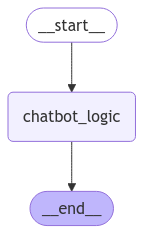

In [27]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from graphviz import Digraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)

# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering questions requiring research or external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define medical keywords and filtering function
MEDICAL_KEYWORDS = [
    "medicine", "symptoms", "diagnosis", "treatment", "disease", "doctor",
    "hospital", "health", "surgery", "therapy", "infection", "pharmacy", "drug"
]

def is_medical_prompt(prompt):
    """Check if the prompt contains medical-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in MEDICAL_KEYWORDS)

# Step 8: Initialize workflow visualization with Graphviz
workflow_graph = Digraph("Chatbot Workflow", format="png")
workflow_graph.attr(rankdir="LR")
workflow_graph.node("Start", shape="ellipse", style="filled", color="lightblue")
workflow_graph.node("Filter Prompt", shape="box", style="filled", color="lightgreen")
workflow_graph.node("Generate Response", shape="box", style="filled", color="lightyellow")
workflow_graph.node("Save to DB", shape="box", style="filled", color="orange")
workflow_graph.node("End", shape="ellipse", style="filled", color="lightblue")
workflow_graph.edges([("Start", "Filter Prompt"), ("Filter Prompt", "Generate Response"),
                      ("Generate Response", "Save to DB"), ("Save to DB", "End")])

def render_workflow():
    """Render and display the workflow graph."""
    workflow_graph.render("chatbot_workflow", view=True)

# Step 9: Chatbot logic with state graph integration
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot_logic(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot_logic", chatbot_logic)
graph_builder.add_edge(START, "chatbot_logic")
graph_builder.add_edge("chatbot_logic", END)
graph = graph_builder.compile()

# Step 10: Chatbot Execution Function
def chatbot():
    print("Welcome to the Medical Chatbot! I only answer medical-related questions.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            render_workflow()
            try:
                display(Image(graph.get_graph().draw_mermaid_png()))
            except Exception:
                print("Graph rendering failed.")
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            workflow_graph.node(user_input, shape="ellipse", style="dashed", color="grey")
            workflow_graph.edge("Start", user_input)

            if is_medical_prompt(user_input):
                workflow_graph.edge(user_input, "Filter Prompt")
                response = agent.run(user_input)
                workflow_graph.edge("Filter Prompt", "Generate Response")
                print(f"Bot: {response}")
                save_to_db(user_input, response)
                workflow_graph.edge("Generate Response", "Save to DB")
            else:
                print("I'm sorry, I can only assist with medical-related questions.")
                workflow_graph.edge(user_input, "Filter Prompt")
                workflow_graph.edge("Filter Prompt", "End")

# Step 11: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


# Eight Section

In [57]:
!pip install -U  langgraph_tools

ERROR: Could not find a version that satisfies the requirement langgraph_tools (from versions: none)
ERROR: No matching distribution found for langgraph_tools


In [68]:
import sqlite3
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts.chat import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from graphviz import Digraph

# Step 1: Set up SQLite Database
def init_db():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS chat_history (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_input TEXT NOT NULL,
            bot_response TEXT NOT NULL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    conn.close()

def save_to_db(user_input, bot_response):
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (user_input, bot_response) VALUES (?, ?)", (user_input, bot_response))
    conn.commit()
    conn.close()

def fetch_history():
    conn = sqlite3.connect("chatbot_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM chat_history ORDER BY timestamp DESC LIMIT 10")
    rows = cursor.fetchall()
    conn.close()
    return rows

# Step 2: Set up Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

# Step 3: Define the conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Step 4: Define the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    temperature=0.7,
    max_tokens=200,
    api_key=gemini_api_key
)


# Step 5: Initialize tools
tools = [
    Tool(
        name="TavilySearch",
        func=tavily_tool.run,
        description="Useful for answering coding-related questions requiring external data."
    )
]

# Step 6: Create the conversational agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
)

# Step 7: Define coding keywords and filtering function
CODING_KEYWORDS = [
    "code", "program", "script", "Python", "JavaScript", "HTML", "CSS", "Java",
    "C++", "debug", "function", "class", "loop", "algorithm", "database", "API", "framework"
]

def is_coding_prompt(prompt):
    """Check if the prompt contains coding-related keywords."""
    return any(keyword.lower() in prompt.lower() for keyword in CODING_KEYWORDS)

# Step 8: Initialize workflow visualization
workflow_graph = Digraph("Chatbot Workflow", format="png")
workflow_graph.attr(rankdir="LR")
workflow_graph.node("Start", shape="ellipse", style="filled", color="lightblue")
workflow_graph.node("Filter Prompt", shape="box", style="filled", color="lightgreen")
workflow_graph.node("Generate Response", shape="box", style="filled", color="lightyellow")
workflow_graph.node("Save to DB", shape="box", style="filled", color="orange")
workflow_graph.node("End", shape="ellipse", style="filled", color="lightblue")
workflow_graph.edges([("Start", "Filter Prompt"), ("Filter Prompt", "Generate Response"),
                      ("Generate Response", "Save to DB"), ("Save to DB", "End")])

def render_workflow():
    """Render and display the workflow graph."""
    workflow_graph.render("chatbot_workflow", view=True)

# Step 9: Implement the chatbot function
def chatbot():
    print("Welcome to the Coding Chatbot! I only assist with coding-related queries.\n")
    print("Type 'exit' to end the conversation.\n")
    print("Type 'history' to view the last 10 conversations.\n")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            render_workflow()  # Display workflow graph at the end
            break
        elif user_input.lower() == "history":
            history = fetch_history()
            if not history:
                print("No history found.")
            else:
                for idx, (id, user, bot, timestamp) in enumerate(history, 1):
                    print(f"{idx}. {timestamp} - You: {user} | Bot: {bot}")
        else:
            workflow_graph.node(user_input, shape="ellipse", style="dashed", color="grey")
            workflow_graph.edge("Start", user_input)

            if is_coding_prompt(user_input):
                workflow_graph.edge(user_input, "Filter Prompt")
                response = agent.run(user_input)
                workflow_graph.edge("Filter Prompt", "Generate Response")
                print(f"Bot: {response}")
                save_to_db(user_input, response)
                workflow_graph.edge("Generate Response", "Save to DB")
            else:
                print("I'm sorry, I can only assist with coding-related questions.")
                workflow_graph.edge(user_input, "Filter Prompt")
                workflow_graph.edge("Filter Prompt", "End")

# Step 10: Initialize and run the chatbot
if __name__ == "__main__":
    init_db()
    chatbot()


Welcome to the Coding Chatbot! I only assist with coding-related queries.

Type 'exit' to end the conversation.

Type 'history' to view the last 10 conversations.

You: Can you generate a navbar
I'm sorry, I can only assist with coding-related questions.
You: exit
Goodbye!
